# Part 1

In [1]:
import csv

train_x = []
with open('data/train_x.csv') as csvfile:
    train_x = list(csv.reader(csvfile))
    
train_x = list(map(lambda x: list(map(lambda y: list(map(float, y.split('-'))), x)), train_x)) 

train_y = []
with open('data/train_y.csv') as csvfile:
    train_y = list(map(int, sum(list(csv.reader(csvfile)), [])))

    
test_x = []
with open('data/test_x.csv') as csvfile:
    test_x = list(csv.reader(csvfile))
    
test_x = list(map(lambda x: list(map(lambda y: list(map(float, y.split('-'))), x)), test_x)) 

test_y = []
with open('data/test_y.csv') as csvfile:
    test_y = list(map(int, sum(list(csv.reader(csvfile)), [])))
    
train_x
train_y

first_indexes_of_class = [(k, train_y.index(k)) for k in sorted(set(train_y))]
first_indexes_of_class

for (k, v) in first_indexes_of_class:
    print(train_x[v])

[[7.0, 6.0], [8.0, 5.0], [9.0, 4.0], [8.0, 5.0], [9.0, 6.0]]
[[7.0, 3.0], [6.0, 2.0], [5.0, 3.0], [4.0, 2.0], [3.0, 3.0]]
[[4.0, 8.0], [5.0, 7.0], [6.0, 6.0], [7.0, 5.0], [8.0, 4.0]]
[[6.0, 9.0], [5.0, 8.0], [6.0, 7.0], [5.0, 8.0], [4.0, 7.0]]


In [2]:
x = '3-8'
list(map(float, x.split('-')))

[3.0, 8.0]

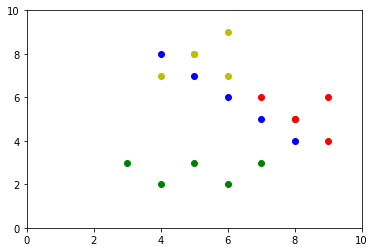

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

colors = ['r', 'g', 'b', 'y']
for i in range(len(train_x[0])):
    for (k, v) in first_indexes_of_class:
        x = list(map(lambda x: x[0], train_x[v]))[i]
        y = list(map(lambda x: x[1], train_x[v]))[i]
        plt.ylim(0, 10)
        plt.xlim(0, 10)
        plt.scatter(x, y, c=colors[k])
        filename='imgs/step'+str(i)+'.png'
        plt.savefig(filename, dpi=96)

// convert -delay 80 *.png animated_walk.gif

<img src="imgs/animated_walk.gif" width="750" align="center">


In [14]:
import torch

train_x_tensor = list(map(torch.tensor, train_x))
train_y_tensor = torch.tensor(train_y)
test_x_tensor = list(map(torch.tensor, test_x))
test_y_tensor = torch.tensor(test_y)

train_x_tensor[0][0].unsqueeze(0)


tensor([[7., 6.]])

# Part 2

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNNClassifier, self).__init__()
        
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=n_layers)
        self.fc = nn.Linear(hidden_size, 32)
        self.fc2 = nn.Linear(32, output_size)
        
    def forward(self, sequence):
        output, _ = self.rnn(sequence.view(len(sequence), 1, -1))
        tag_space = self.fc2(self.fc(output.view(len(sequence), -1)))
        return tag_space

    
classifier = RNNClassifier(2, 16, 4, n_layers=2)

print("Sanity check")
test_output = classifier(train_x_tensor[0])
print('test output')
print(test_output)
test_loss_function = nn.NLLLoss()
loss = test_loss_function(test_output,
                          torch.tensor([1,1,1,1,1]))
print(loss)

output = torch.argmax(test_output[-1])
print(output.item())

Sanity check
test output
tensor([[ 0.0546,  0.0526, -0.1477, -0.1951],
        [-0.1265,  0.0336, -0.1225, -0.3033],
        [-0.1539,  0.1204, -0.1984, -0.3383],
        [-0.0570,  0.0927, -0.1143, -0.2573],
        [-0.0825,  0.1006, -0.1194, -0.2566]], grad_fn=<AddmmBackward>)
tensor(-0.0800, grad_fn=<NllLossBackward>)
1


In [19]:
base_model = RNNClassifier(2, 16, 4, n_layers=2)
base_loss_function = nn.CrossEntropyLoss()
base_optimizer = torch.optim.SGD(base_model.parameters(), lr=0.001)

for epoch in range(30):
    loss = 0
    print(f"Epoch {epoch+1}")
    
    for i in range(len(train_x_tensor)):
        data_input = train_x_tensor[i]
        target = torch.tensor([train_y[i] for _ in range(5)])
        
        if epoch == 0:
            data_input = data_input[1:] if i % 2 == 0 else data_input[:-1]
            target = torch.tensor([train_y[i] for _ in range(4)])
        
            
        tag_scores = base_model(data_input)
        base_optimizer.zero_grad()
        
        loss = base_loss_function(tag_scores,target)
        
        if i % 4000 == 0:
            print(f"{i} iteration, loss_for_item: {loss}")
            
        loss.backward()
        base_optimizer.step()
    
    with torch.no_grad():
        correct = 0

        for i in range(len(test_x_tensor)):
            tag_scores = base_model(test_x_tensor[i])
            predicted = torch.argmax(tag_scores[-1]).item()
            target = test_y[i]
            
            if predicted == target:
                correct += 1
        
        accuracy_test = correct/len(test_x_tensor)
                
        print(f"Accuracy test:  {accuracy_test}")
        
        if accuracy_test > 0.65:
            print("Accuracy reached 0.65; break")
            break
        

Epoch 1
0 iteration, loss_for_item: 1.7063796520233154
4000 iteration, loss_for_item: 1.4302397966384888
8000 iteration, loss_for_item: 1.460371494293213
Accuracy test:  0.435
Epoch 2
0 iteration, loss_for_item: 1.2604193687438965
4000 iteration, loss_for_item: 1.2244865894317627
8000 iteration, loss_for_item: 1.4706571102142334
Accuracy test:  0.509
Epoch 3
0 iteration, loss_for_item: 1.1528326272964478
4000 iteration, loss_for_item: 1.1407209634780884
8000 iteration, loss_for_item: 1.4299938678741455
Accuracy test:  0.541
Epoch 4
0 iteration, loss_for_item: 1.1102242469787598
4000 iteration, loss_for_item: 1.1139764785766602
8000 iteration, loss_for_item: 1.3477251529693604
Accuracy test:  0.562
Epoch 5
0 iteration, loss_for_item: 1.0834349393844604
4000 iteration, loss_for_item: 1.0935229063034058
8000 iteration, loss_for_item: 1.2059314250946045
Accuracy test:  0.588
Epoch 6
0 iteration, loss_for_item: 1.0958333015441895
4000 iteration, loss_for_item: 1.0028369426727295
8000 iterat

# Part 3

In [4]:
import random

random_mapping = {}

def generate_random_mapping_for_entry(entry):
    if random_mapping.get(entry) is not None:
        return
    
    while True:
        suggested_entry = random.randint(0, 99)
        
        if suggested_entry in random_mapping.values():
            continue
            
        random_mapping[entry] = suggested_entry
        return
    
for sequence in train_x + test_x:
    for node in sequence:
        generate_random_mapping_for_entry((int(node[0]), int(node[1])))
    
print(random_mapping)
        

{(7, 6): 60, (8, 5): 49, (9, 4): 70, (9, 6): 92, (7, 3): 65, (6, 2): 4, (5, 3): 25, (4, 2): 95, (3, 3): 69, (6, 9): 13, (5, 8): 66, (6, 7): 72, (4, 7): 61, (4, 4): 99, (3, 5): 24, (3, 7): 93, (2, 8): 82, (1, 7): 64, (0, 9): 52, (1, 8): 53, (0, 7): 27, (8, 4): 5, (9, 3): 88, (8, 2): 33, (8, 3): 86, (7, 4): 15, (4, 8): 51, (5, 7): 97, (6, 6): 6, (7, 5): 90, (0, 2): 8, (1, 1): 21, (0, 0): 94, (7, 1): 31, (6, 0): 59, (5, 1): 87, (4, 0): 41, (3, 1): 2, (2, 2): 35, (5, 2): 46, (4, 3): 48, (5, 4): 7, (6, 5): 96, (3, 6): 20, (2, 7): 73, (3, 8): 40, (3, 0): 63, (4, 1): 18, (5, 0): 54, (6, 1): 34, (7, 2): 30, (9, 2): 11, (6, 3): 9, (9, 5): 1, (9, 7): 71, (8, 8): 12, (9, 9): 42, (4, 6): 26, (5, 5): 16, (6, 4): 75, (8, 6): 56, (3, 4): 89, (2, 5): 80, (1, 6): 83, (4, 9): 10, (7, 8): 91, (8, 9): 32, (9, 8): 58, (8, 7): 50, (2, 9): 62, (2, 6): 45, (2, 4): 57, (0, 3): 74, (1, 2): 28, (1, 4): 23, (0, 5): 76, (9, 1): 14, (5, 6): 78, (4, 5): 38, (8, 0): 19, (7, 7): 77, (1, 5): 85, (3, 9): 3, (5, 9): 17, 

In [5]:
train_x_embedded_input = torch.tensor([list(map(lambda x: random_mapping[(x[0], x[1])], sequence)) for sequence in train_x])
test_x_embedded_input = torch.tensor([list(map(lambda x: random_mapping[(x[0], x[1])], sequence)) for sequence in test_x])
train_x_embedded_input

tensor([[60, 49, 70, 49, 92],
        [65,  4, 25, 95, 69],
        [13, 66, 72, 66, 61],
        ...,
        [90,  6, 97, 51,  3],
        [26, 93, 45, 85, 57],
        [67, 21, 35, 21,  8]])

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmbeddedRNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, vocab_size=100, embedding_dim=2, n_layers=1, debug=False, fc_layers=64):
        super(EmbeddedRNNClassifier, self).__init__()
        
        self.debug = debug
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        self.rnn = nn.GRU(input_size=embedding_dim, hidden_size=hidden_size, num_layers=n_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, sequence):
        embeds = self.word_embeddings(sequence)
        
        if self.debug:
            print(f"Embeds {embeds.shape}")
            print(embeds)
        output, _ = self.rnn(embeds.view(len(sequence), 1, -1))
        tag_space = self.fc(output.view(len(sequence), -1))
        return tag_space
    
    def get_word_embeddings(self):
        return self.word_embeddings

    
classifier = EmbeddedRNNClassifier(1, 16, 4, n_layers=2, debug=True)

print("Sanity check")
test_output = classifier(train_x_embedded_input[0])
print('test output')
print(test_output)
test_loss_function = nn.NLLLoss()
loss = test_loss_function(test_output,
                          torch.tensor([1,1,1,1,1]))
print(loss)

output = torch.argmax(test_output[-1])
print(output.item())

Sanity check
Embeds torch.Size([5, 2])
tensor([[-2.4630, -0.1817],
        [ 0.6813,  1.2632],
        [ 0.8127,  0.0718],
        [ 0.6813,  1.2632],
        [-1.7003,  1.0058]], grad_fn=<EmbeddingBackward>)
test output
tensor([[ 0.0493, -0.0240,  0.2718,  0.2054],
        [ 0.0143,  0.0059,  0.3272,  0.2290],
        [-0.0168,  0.0351,  0.3411,  0.2685],
        [-0.0388,  0.0664,  0.3558,  0.2722],
        [-0.0261,  0.0412,  0.3901,  0.2286]], grad_fn=<AddmmBackward>)
tensor(-0.0249, grad_fn=<NllLossBackward>)
2


In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = EmbeddedRNNClassifier(1, 64, 4, embedding_dim=2, n_layers=4)
model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

points_to_embed = [(0, 1), (1, 0), (6, 8), (7, 9)]
embeddings = {}

for point in points_to_embed:
    embeddings[point] = {"x": [], "y":[]}

    
print("Running...")

train_x_embedded_input_tensor = train_x_embedded_input.to(device)
test_x_embedded_input_tensor = test_x_embedded_input.to(device)
train_y_tensor = torch.tensor([[train_y[i] for _ in range(5)] for i in range(len(train_y))]).to(device)
test_y_tensor = torch.tensor([[train_y[i] for _ in range(5)] for i in range(len(test_y))]).to(device)

for epoch in range(100):
    loss = 0
    
    for i in range(len(train_x_embedded_input_tensor)):
        data_input = train_x_embedded_input_tensor[i]
        target = train_y_tensor[i]
        
        tag_scores = model(data_input)
        optimizer.zero_grad()
        
        loss = loss_function(tag_scores,target) 
            
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        correct = 0

        for i in range(len(test_x_embedded_input_tensor)):
            data_input = test_x_embedded_input_tensor[i]
            tag_scores = model(data_input)
            predicted = torch.argmax(tag_scores[-1]).item()
            target = test_y[i]
            
            if predicted == target:
                correct += 1
        
        accuracy_test = correct/len(test_x_embedded_input)
                
        print(f"Epoch {epoch+1} Accuracy test:  {accuracy_test}")
        
        for point in points_to_embed:
            point_embedding = model.get_word_embeddings()(torch.tensor(random_mapping[point]).to(device))    
            embeddings[point]["x"].append(point_embedding[0].to('cpu').item())
            embeddings[point]["y"].append(point_embedding[1].to('cpu').item())

        if accuracy_test >= 0.65:
            print("Accuracy reached 0.65; break")
            break
            
    scheduler.step()
        

Running...
Epoch 1 Accuracy test:  0.248
Epoch 2 Accuracy test:  0.248
Epoch 3 Accuracy test:  0.248
Epoch 4 Accuracy test:  0.248
Epoch 5 Accuracy test:  0.251
Epoch 6 Accuracy test:  0.291
Epoch 7 Accuracy test:  0.317
Epoch 8 Accuracy test:  0.341
Epoch 9 Accuracy test:  0.357
Epoch 10 Accuracy test:  0.367
Epoch 11 Accuracy test:  0.399
Epoch 12 Accuracy test:  0.392
Epoch 13 Accuracy test:  0.398
Epoch 14 Accuracy test:  0.395
Epoch 15 Accuracy test:  0.39
Epoch 16 Accuracy test:  0.472
Epoch 17 Accuracy test:  0.488
Epoch 18 Accuracy test:  0.51
Epoch 19 Accuracy test:  0.544
Epoch 20 Accuracy test:  0.566
Epoch 21 Accuracy test:  0.588
Epoch 22 Accuracy test:  0.599
Epoch 23 Accuracy test:  0.597
Epoch 24 Accuracy test:  0.622
Epoch 25 Accuracy test:  0.634
Epoch 26 Accuracy test:  0.64
Epoch 27 Accuracy test:  0.64
Epoch 28 Accuracy test:  0.644
Epoch 29 Accuracy test:  0.646
Epoch 30 Accuracy test:  0.642
Epoch 31 Accuracy test:  0.657
Accuracy reached 0.65; break


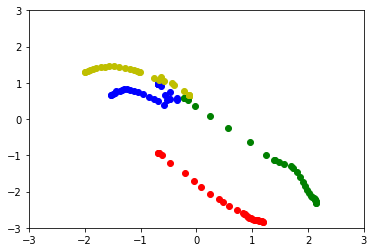

In [10]:
import matplotlib.pyplot as plt

epochs_length = len(embeddings[points_to_embed[0]]["x"])

colors = ['r', 'g', 'b', 'y']

for e in range(epochs_length):
    for i,k in enumerate(embeddings.keys()):
        x = [embeddings[k]["x"][e]]
        y = [embeddings[k]["y"][e]]
        plt.ylim(-3, 3)
        plt.xlim(-3, 3)
        plt.scatter(x, y, c=colors[i])
        epoch_name = str(e) if e >= 10 else "0" + str(e)
        filename='imgs2/epoch'+epoch_name+'.png'
        plt.savefig(filename, dpi=96)

<img src="imgs2/animated_embed.gif" width="750" align="center">

red - (0,1)
green - (1,0)
blue - (6,8)
yellow - (7,9)